## Question

[Word Embedding via word2vec] Start by creating your own training data, composed of 30 pairs of words, where each pair corresponds to target and context words having similarity. For example, in the “King and queen” dataset (see the wevi demo at https://ronxin.github.io/wevi/), pairs include but not limited to 1) (king, kingdom), 2) (king, palace), 3) (queen, royal), and so on. Find embedding vectors of all words in the training data based on the word2vec model. Adopt the stochastic gradient descent (SGD) optimizer and hyperparameters set to the following values:
- hidden layer dimension: 5
- learning rate: 0.1
which can however be replaced by other ones if another setting leads to a better result. You may set other hyperparameters arbitrarily. Do NOT use any approximation techniques (such as Hierarchical Softmax) to compute the probability distribution. To show the convergence, plot the loss versus the number of epochs using the above training data. Additionally, plot all resulting vectors on the two- dimensional space using the t-SNE visualization tool. Use the Scikit-Learn package on Python by changing the default setting on ‘perplexity’ to a small value. Verify that similar words tend to be collocated on the embedding space.

## Solution

In [5]:
import numpy as np
import matplotlib.pyplot as plt # python의 데이터 시각화 라이브러리
from sklearn.manifold import TSNE

# 단어 목록 및 쌍 설정
geography_pairs = [
    ('South Korea', 'Seoul'), ('Mexico', 'Mexico City'),  ('France', 'Paris'),
    ('Japan', 'Tokyo'), ('USA', 'Washington'),  ('Russia', 'Moscow'),
    ('Brazil', 'Brasilia'), ('India', 'New Delhi'), ('Canada', 'Ottawa'),
    ('Australia', 'Canberra'), ('Egypt', 'Cairo'), ('South Africa', 'Cape Town'),
    ('Germany', 'Berlin'), ('United Kingdom', 'London'), ('Argentina', 'Buenos Aires'),
    ('Spain', 'Madrid'), ('Turkey', 'Ankara'), ('China', 'Beijing'),
    ('Italy', 'Rome'), ('Saudi Arabia', 'Riyadh'), ('Nigeria', 'Lagos')
]

지리적 데이터를 활용하여 국가와 그 국가의 수도를 연결하는 단어 쌍을 생성했다.
각 쌍은 특정 국가를 target으로 하였고, 해당 국가의 수도를 context로 하였다.

In [6]:
# 단어 인덱싱
countries, cities = zip(*geography_pairs)
unique_words = list(set(countries + cities))
word_to_index = {word: i for i, word in enumerate(unique_words)}
word_size = len(unique_words)

python의 zip()함수를 사용해 geography_pairs를 countries(국가), cities(수도)에 정수 index를 할당하였다.
그 후 단어들을 각 고유 index와 연결하는 dictionary를 구성하여 벡터 연산을 가능하게 했다.

countries에는 국가들이, cities에는 수도들이 담긴다.

unique_words는 countries + cities를 중복 제거하여 하나의 리스트로 결합한다.

word_to_index는 enumerate 함수를 사용하여 unique_words 리스트의 각 단어에 고유한 인덱스를 할당하여 단어를 식별 가능한 index를 매핑한다.

word_size는 리고유 단어 총 개수를 나타낸다. 모델의 입력 레이어와 출력 레이어에 사용될 단어의 수(word 크기)를 정의한다.

In [7]:
# hyperparameters 설정
hidden_size = 5 # hidden layer 노드 수
learning_rate = 0.1 # 가중치 업데이트 속도
epochs = 150 # 학습 수

# 가중치 초기화
w1 = np.random.randn(word_size, hidden_size) # input layer과 hidden layer 사이 가중치 초기화
w2 = np.random.randn(hidden_size, word_size) # hidden layer과 output layer 사이 가중치 초기화

문제에 제시된 hyperparameter 설정한 후, 가중치를 평균이 0이고 표준편차가 1인 가우시안 분포를 따르는 난수로 설정했다.

In [8]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

softmax 함수는logit 벡터를 입력으로 받아, 각 단어에 대한 확률 분포로 변환해 단어 간 확률 비교한다.

입력 x의 각 요소에서 x의 최대값을 빼고 그 결과에 지수 함수를 적용한다.
이러한 지수화된 값을 모두 더해 총합으로 나누어, 출력 값의 합이 1이 되도록 정규화한다.
그 후 각 단어가 선택될 확률을 나타내는 벡터를 반환한다.

In [9]:
# 훈련 데이터 생성
def create_training_data(pairs, word_to_idx):
    X_train = []
    for target, context in pairs:
        x = np.zeros(len(word_to_idx))
        y = word_to_idx[context]
        x[word_to_idx[target]] = 1
        X_train.append((x, y))
    return X_train

create_training_data 함수는 국가와 수도의 단어쌍을 입력으로 받아, 모델이 처리할 수 있는 형식으로 변환하는 역할을 한다.
이 함수는 word2vec모델에서 사용될 one-hot 인코딩 벡터를 생성한다.

변수 x에 각 target 단어에 대해 0으로 채워진 벡터를 할당 한다. 벡터의 크기는 단어의 크기로 한다.
변수 y에 context 단어에 대한 인덱스를 할당한다. 향후 모델이 예측해야 할 대상(label)이다.

그 후, target 단어의 인덱스에 해당하는 위치에 1을 설정하여 해당 단어를 one-hot 인코딩한다.

X_train 리스트에 생성된 one-hot 인코딩 벡터 x와 정답 label y를 튜플로 묶어 추가한 후, return한다.

In [10]:
training_data = create_training_data(geography_pairs, word_to_index)

# 훈련 루프
losses = [] # epoch마다 계산된 손실을 저장하는 리스트
for epoch in range(epochs):
    epoch_loss = 0
    for x, y_true in training_data:
        # forward pass
        h = np.dot(w1.T, x) # hidden layer activations
        u = np.dot(w2.T, h) # output layer (softmax적용 전)
        y_predict = softmax(u) # output layer activations
        
        # Loss 계산(예측값과 실제값이 얼마나 잘 일치하는지 측정)
        epoch_loss += -np.log(y_predict[y_true])
        
        # backward pass
        dy = y_predict
        dy[y_true] -= 1
        
        dw2 = np.outer(h, dy)
        dh = np.dot(w2, dy)
        dw1 = np.outer(x, dh)
        
        # weight 업데이트
        w1 -= learning_rate * dw1
        w2 -= learning_rate * dw2
    
    epoch_loss /= len(training_data)
    losses.append(epoch_loss)

forward pass에서 변수 h에 입력 벡터 x와 가중치 w1의 전치를 내적하여 hidden layer의 activation을 계산한다. input layer -> hidden layer 신호 전달을 나타낸다.
hidden layer의 활성화 h와 가중치 w2의 전치를 내적하여 output layer의 activation을 계산하여 변수 u에 저장한다. u는 softmax 적용 전 값이다.
출력층의 logit u에 softmax 함수를 적용해 각 클래스(단어)에 대한 예측 확률 분포를 얻는다.

loss 계산은 실제 단어 y_true에 해당하는 예측 확률 y_pred[y_true]의 로그 값을 취한 후 음수로 취해 epoch 손실에 더한다.

backward pass는 prediction 확률에 대한 손실 미분을 계산하고 손실 함수의 미분 공식에 따라 실제 단어위치에서 gradient를 조정한다.
dw2 변수는 hidden layer activation h와 output layer dy의 외적을 통해 w2의 gradient를 계산한다.
dh 변수는 weight w2와 ouput layer gradient 내적을 통해 hidden layer gradient를 계산한다.
dw1 변수는 입력 벡터 x와 hidden layer gradient dh의 외적을 통해 w1의 gradient를 계산한다.

weight 업데이트는 계산된 gradient에 learning rate를 곱한 값을 현재 weight에서 빼주어 weight를 업데이트한다.

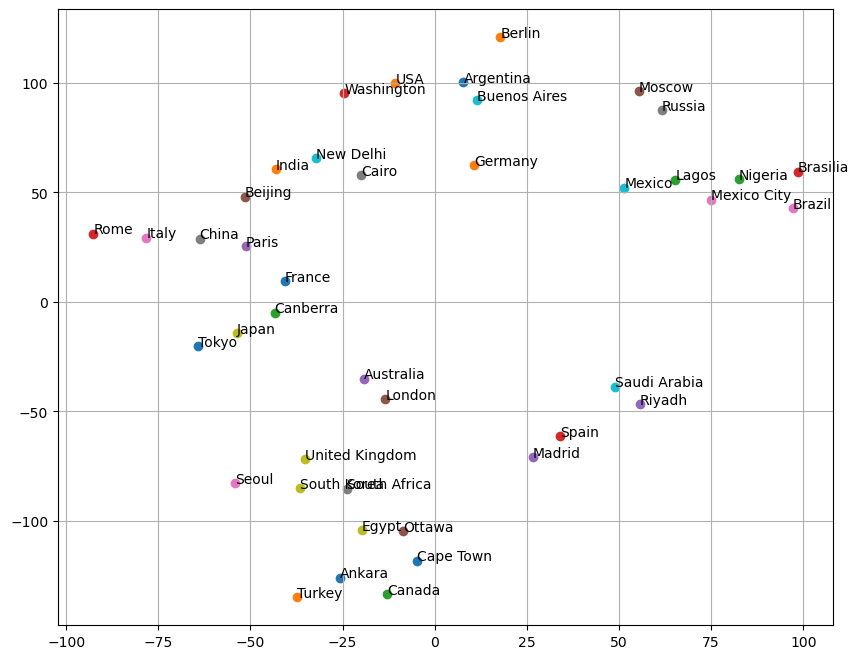

In [11]:
# t-SNE 시각화(2차원 공간)
word_vectors = w1 + w2.T
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)

# t-SNE 결과
plt.figure(figsize=(10, 8))
for word, (x, y) in zip(unique_words, word_vectors_2d):
    plt.scatter(x, y)
    plt.annotate(word, (x, y), fontsize=10)
plt.grid(True)
plt.show()

w1과 w2.T(output layer weight 전치)를 합쳐 각 단어에 대한 새로운 벡터를 생성한다.

TSNE 객체를 설정하고 fit_transform 함수를 사용해 단어 벡터를 2차원으로 축소한다.

plt.scatter를 사용하여 축소된 벡터를 그래프에 표시하고, plt.annotate로 각 점에 해당하는 단어를 표기한다. 이를 통해 단어들이 의미적으로 얼마나 가깝게 위치하는지 비슷한 단어들이 공간에서 얼마나 근접하게 집단을 이루는지 보여준다.